# Test Code for Prob & Stats Final Project

In [2]:
from typing import Union, List, Iterable, Tuple
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import pandas_datareader.data as web
# import fix_yahoo_finance as yf
from pandas_datareader import data as web
import yfinance as yf
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

### Define all functions

In [14]:
def plot_hist(df: pd.DataFrame, symbol: Union[str, List[str]] = None):
    """
    Plot histogram(s) of log-return(s) of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
    """
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
    
    ncols = min(2, len(symbol))
    nrows = math.ceil(len(symbol) / 2)
    figsize = (5 * ncols, 4 * nrows)
    
    log_return[symbol].hist(bins = 50, figsize = figsize)
    plt.title(f'Histogram o Log-return of {symbol}')
    plt.xlabel('log return')
    plt.ylabel('frequency')
    plt.show()
    

def probplot(df, symbol: Union[str, List[str]] = None):
    """
    Plot normal probability plot(s) of log-return(s) 
    of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
    """
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
        
    ncols = min(2, len(symbol))
    nrows = math.ceil(len(symbol) / 2)
    figsize = (5 * ncols, 4 * nrows)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    
    if not isinstance(axs, Iterable):
        axs = [[axs]]

    for i, sym in enumerate(symbol):
        r = i//2
        c = i%2
        res = stats.probplot(log_return[sym], plot=axs[r][c])
        axs[r][c].set_title(sym)
        

def confidence_interval(df: pd.DataFrame, 
                        symbol: Union[str, List[str]] = None, 
                        conf_level: float = 0.95
                       ) -> pd.DataFrame:
    """
    Computes confidence intervals of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
        conf_level: confidence level. Default is 0.95.
        
    Returns:
        Dataframe with 2 columns ['lower_bound', 'uppe_bound'],
            each row corresponds to each symbol.
    """
    
    alpha = (1 - conf_level)
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
    
    sample_mean = df[symbol].mean()
    sample_variance = df[symbol].var()
    
    t_value = scipy.stats.t.ppf(1 - (alpha / 2), len(df[symbol]) - 1)
    diff = t_value * np.sqrt(sample_variance / len(df[symbol]))

    lower_bound = sample_mean - diff
    lower_bound.name = 'lower_bound'
    
    upper_bound = sample_mean + diff
    upper_bound.name = 'upper_bound'

    return pd.concat([lower_bound, upper_bound], axis = 1)


def mean_equality_test(df: pd.DataFrame, 
                       symbol_1: str, 
                       symbol_2: str, 
                       conf_level: float = 0.95
                      ) -> bool:
    """
    Tests the equality of population means of of 2 symbols' log-returns using
    hypothesis testing, where:
    H0: Population means of both symbols are equal.
    H1: Otherwise.
    
    Assumption:
    - There is dependency between the 2 symbol and thus, paired test has to be employed.
    
    Args:
        df: Dataframe of log-returns.
        symbol_1: Symbol of the first stock.
        symbol_2: Symbol of the second stock.
        conf_level: confidence level. Default is 0.95.
        
    Returns:
        Whether to accept the null hypothesis. I.E. return True if population means 
            of both symbols are equal. False otherwise.
    """
    
    alpha = (1 - conf_level)
    
    diff = df[symbol_1] - df[symbol_2]
    diff_mean = diff.mean()
    diff_var = diff.var()
    
    
    t_stat = diff_mean / np.sqrt(diff_var/len(diff))
    
    z = scipy.stats.t.ppf(1 - (alpha / 2), len(diff) - 1)
    
    return np.abs(t_stat) <= z

In [4]:
def regression(x: Iterable, 
               y: Iterable, 
               x_label: str = None, 
               y_label: str = None
              ) -> Tuple[float, float, float]:
    
    """
    Performs regression on given pair of x and y.
    
    Args:
        x: x values
        y: y values
        x_label: label of the x.
        y_label: label of the y.
        
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    
    intercept, slope = model.params
    rsquared = model.rsquared
    resid = model.resid
    
    best_fit = intercept + slope * np.array(x)
    
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(5, 8))
    axs[0].scatter(x, y, label = 'log_return')
    axs[0].plot(x, best_fit, 'r', label = 'best_fit')
    axs[0].legend()
    axs[0].title.set_text('best fit plot')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)
    
    axs[1].scatter(x, resid)
    axs[1].title.set_text('residual plot')
    axs[1].set_xlabel(x_label)
    axs[1].set_ylabel('residual')
    
    plt.subplots_adjust(hspace=0.25)
    
    plt.show()
    
    return intercept, slope, rsquared 


def return_time_reg(df, symbol: str) -> Tuple[float, float, float]:

    """
    Performs regression on a single symbol against the time (day).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol of the stock.
    
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    return regression(list(range(len(df))), 
                      df[symbol], 
                      x_label='day', 
                      y_label=f'log return of {symbol}'
                     )


def return_reg(df, symbol_x: str, symbol_y: str) -> Tuple[float, float, float]:
    
    """
    Performs regression on a symbol against another symbol.
    
    Args:
        df: Dataframe of log-returns.
        symbol_x: Symbol of stock on x-axis.
        symbol_y: Symbol of stock on y-axis.
    
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    return regression(df[symbol_x], 
                      df[symbol_y], 
                      x_label=f'log return of {symbol_x}', 
                      y_label=f'log return of {symbol_y}'
                     )

### Load Data

In [5]:
# Input
symbols = ['HSBA.L','NWG.L','TSCO.L','BARC.L', 'LLOY.L'] 

raw_data = yf.download(symbols, start = '2016-06-23', end='2016-8-23')

[*********************100%***********************]  5 of 5 completed


### Plot graph of prices

[]

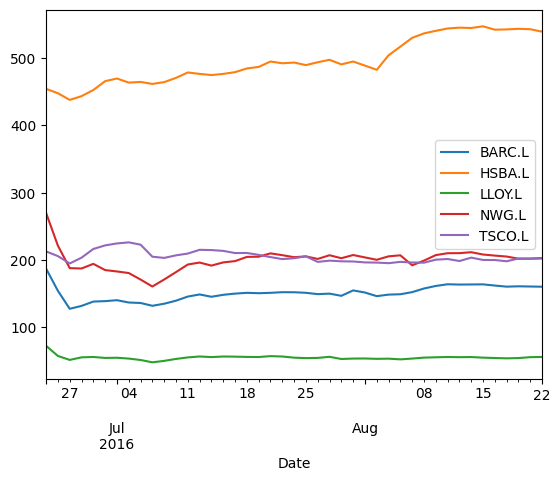

In [6]:
raw_data['Close'].plot()
plt.plot()

### Compute Log-Return

In [7]:
log_return = np.log(raw_data['Close'] / raw_data['Open'])

### Plot Histogram(s)

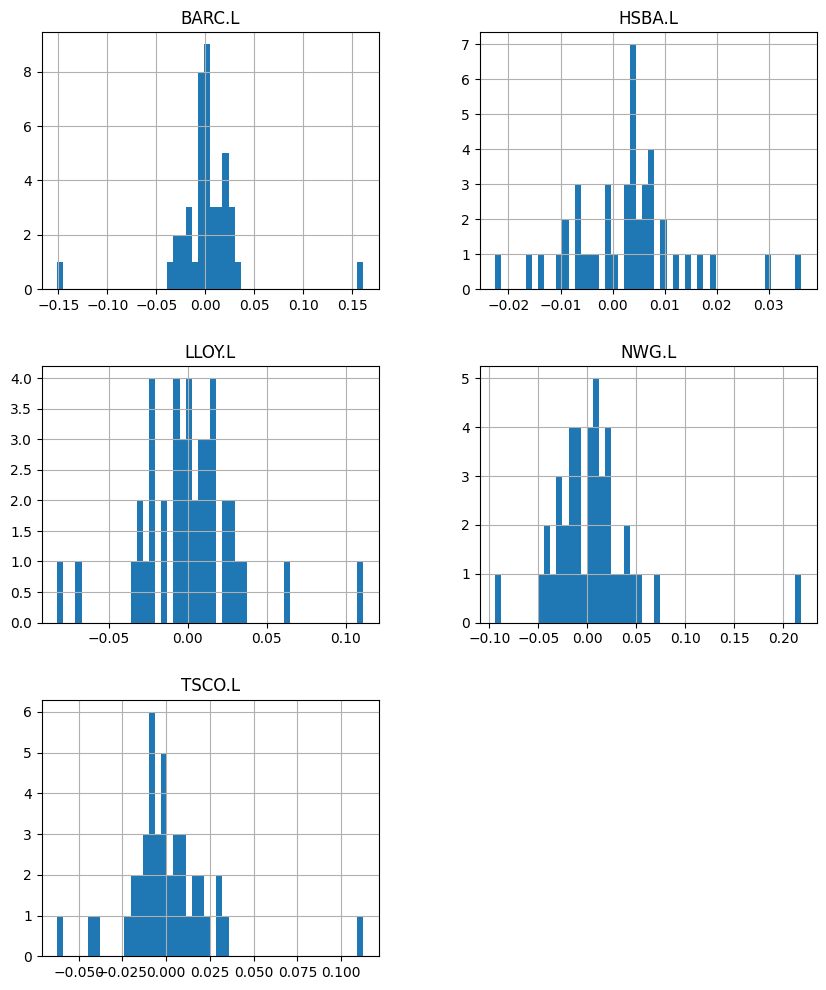

In [8]:
plot_hist(log_return)  # Specify symbol=[SYMBOL] to plot only 1 symbol.

### Plot Normal Probability Plot(s)

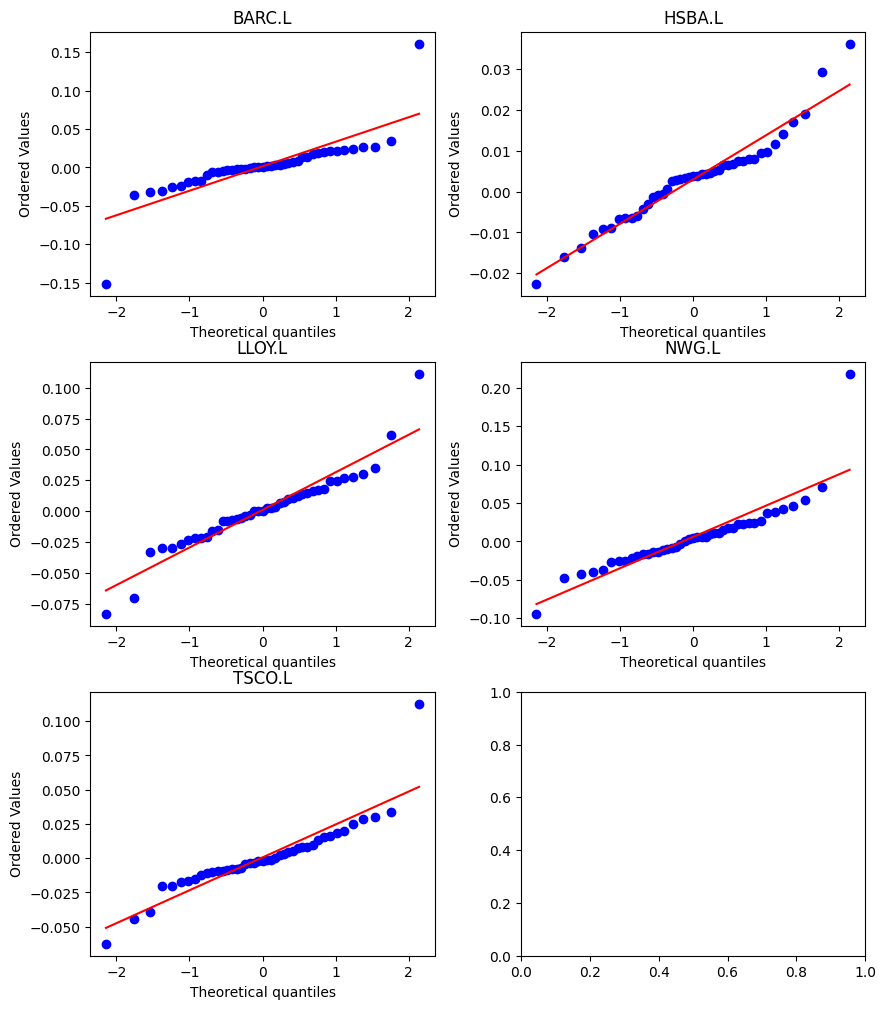

In [9]:
probplot(log_return)  # Specify symbol=[SYMBOL] to plot only 1 symbol.

### Compute Confidence Interval(s) of given symbol(s)

In [10]:
confidence_interval(log_return, conf_level=0.05)  # Specify symbol=[SYMBOL] to compute only a subset of symbols.

,lower_bound,upper_bound
BARC.L,0.001159,0.001891
HSBA.L,0.002871,0.003080
LLOY.L,0.000775,0.001374
NWG.L,0.005496,0.006363
TSCO.L,0.000368,0.000863


### Run Regression for a symbol against time.

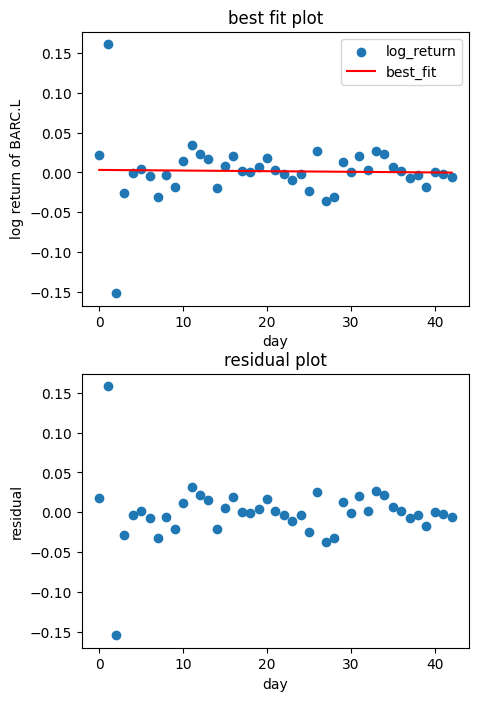

Intercept: 0.0031826796031775117
Slope: -7.894155675500384e-05
R squared: 0.0006797688301434235


In [11]:
intercept, slope, rsquared  = return_time_reg(log_return, 'BARC.L')
print('Intercept:', intercept)
print('Slope:', slope)
print('R squared:', rsquared)

### Run Regression for a symbol against another symbol.

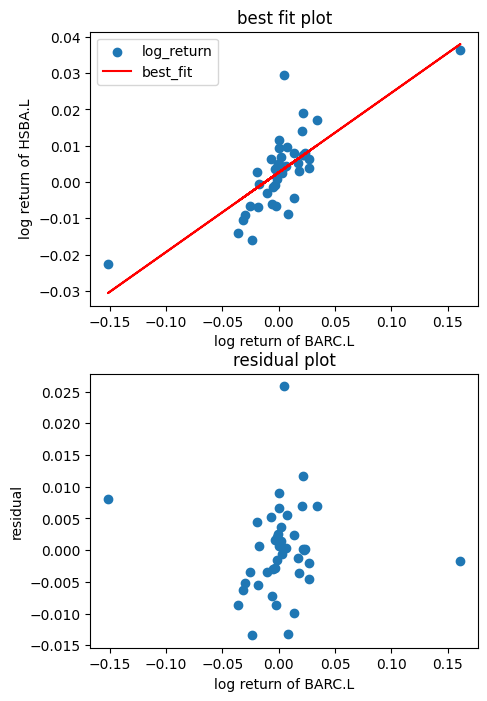

Intercept: 0.0026410750815597434
Slope: 0.21942383160595882
R squared: 0.5892778821715943


In [12]:
intercept, slope, rsquared  = return_reg(log_return, 'BARC.L', 'HSBA.L')
print('Intercept:', intercept)
print('Slope:', slope)
print('R squared:', rsquared)

### Test the equality of population means of a pair of symbols.

In [15]:
symbol_1 = 'BARC.L'
symbol_2 = 'HSBA.L'
res = mean_equality_test(log_return, symbol_1, symbol_2)
print(f"Are population means of {symbol_1} and {symbol_2} euqal?: {res}")

Are population means of BARC.L and HSBA.L euqal?: True
